In [53]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from scipy.optimize import curve_fit
from scipy import optimize
import sys,os, os.path,shutil
import glob
from reshape import *
from fit import *
from coverage import *
from lmfit import Model
from lmfit import Minimizer, Parameters, report_fit

In [54]:
def plot(img,radius_x,radius_y,distance=0.05):

    x_x,x_line,y_y,y_line = info(img)
    
    fig=plt.figure(figsize=(9.75,10))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    #left graph --------------------------------

    ax1 = plt.subplot(221)

    plt.grid(True, linestyle = "-.", color = "grey", linewidth = "0.5")
    plt.ylabel('distance_x mm')
    plt.xlabel('power [arb.unit]')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    
    y_y=np.arange(len(y_line))
    plt.xlim(0,100)
    plt.ylim(len(y_y)*5.2/1000,0)
    plt.scatter(y_line/255*100,y_y*5.2/1000,s=1,c="b",alpha=0.5)

    #bottom graph --------------------------------

    ax2 = plt.subplot(224)
    
    plt.grid(True, linestyle = "-.", color = "grey", linewidth = "0.5")
    plt.xlabel('distance_y mm')
    plt.ylabel('power [arb.unit]')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right') 
    
    x_x=np.arange(len(x_line))
    plt.xlim(0,len(x_x)*5.2/1000)
    plt.ylim(0,100)
    plt.scatter(x_x*5.2/1000,x_line/255*100,s=1,c="b",alpha=0.5)
    
    #image --------------------------------

    ax0 = plt.subplot(222,aspect='auto')
    cax=plt.imshow(img/255*100,cmap=plt.cm.inferno)
    plt.axis('off')
    
    #colourbar ----------------------------
    cbar_ax = fig.add_axes([0.92, 0.52, 0.02, 0.36])
    fig.colorbar(cax, cax=cbar_ax)
    
    #slope --------------------------------
    
    radius_x.sort(0)
    radius_y.sort(0)
    
    radius_x = radius_x*5.2/1000
    radius_y = radius_y*5.2/1000
    
    a = np.arange(0,len(radius_x))
    a = a*distance
    
    ax3=plt.subplot(223,aspect='auto')
    
    #plt.ylim(0,a.max())
    plt.grid(True, linestyle = "-.", color = "grey", linewidth = "0.5")
    plt.ylabel('radius mm')
    plt.xlabel('distance mm')
    
    plt.scatter(a,radius_x,s=1,c="r",alpha=1,label='x-axis')
    plt.scatter(a,radius_y,s=1,c="b",alpha=1,label='y-axis')
    
    #parameter for fitting --------------------------------
    
    p_line = {
    'a': {'value': 0.2}, 
    'b': {'value': min(x_line)}, 
    }
    
    p_gau = {
    'a': {'value': max(x_line)/2}, 
    'b': {'value': min(x_line)},
    'x0': {'value': len(x_x)/2}, 
    'sigma': {'value': 30},
    }
    
    #linear fitting --------------------------------
    
    x_plot,model,out=fit(linear,p_line,a,radius_x)
    
    ax3.plot(x_plot, model(out.params, x_plot), 'r', alpha = 0.5)
    slope1=out.params["a"].value
    stderr1=out.params['a'].stderr
    b1=out.params["b"].value
    
    x_plot,model,out=fit(linear,p_line,a,radius_y)
    ax3.plot(x_plot, model(out.params, x_plot), 'b', alpha = 0.5)
    
    slope2=out.params["a"].value
    stderr2=out.params['a'].stderr
    b2=out.params["b"].value
    
    def w_cal(a,slope,b,radius):     
        zero = -b/slope
        z0 = np.ones(len(a)) - zero
        w = radius*1e-3 #from mm to m
        z = (a + z0)*1e-3 #from mm to m
        λ = 850e-9
        w0= np.mean((z*λ)/(3.14*w))*1e6 #from m to µm

        degree=np.arctan(slope)
        M2=np.mean((degree*np.pi*((z*λ)/(3.14*w)))/λ)

        return w0,zero,M2
    
    w0_x,zero_x,M2_x=w_cal(a,slope1,b1,radius_x)
    w0_y,zero_y,M2_y=w_cal(a,slope2,b2,radius_y)          
        
    degree_x = np.arctan(slope1)/3.14*180
    degree_y = np.arctan(slope2)/3.14*180
    
    ax3.text(0.98, 0.02, """
    
    w0_x:%.2f µm, z0_x:%.2f mm
    w0_y:%.2f µm, z0_y:%.2f mm
    X:slope:%.2f, deg:%.2f(stderr %.3f)
    Y:slope:%.2f, deg:%.2f(stderr %.3f)""" %(w0_x,zero_x,w0_y,zero_y,
                                                   slope1,degree_x,stderr1,
                                                   slope2,degree_y,stderr2),
            fontsize=12, horizontalalignment='right',
            verticalalignment='bottom', transform=ax3.transAxes)
    
    
    #gaussian fitting --------------------------------
    
    x_plot,model_x,out_x=fit(gaussian,p_gau,x_x,x_line)
    ax2.plot(x_plot*5.2/1000, model_x(out_x.params,x_plot)/255*100, 'r',alpha = 0.5)
    x_gau_sum=plot_sum(x_plot*5.2/1000,(model_x(out_x.params, x_plot)-min(model_x(out_x.params, x_plot)))/255*100) 
    
    
    y_plot,model_y,out_y=fit(gaussian,p_gau,y_y,y_line)
    ax1.plot(model_y(out_y.params, y_plot)/255*100,y_plot*5.2/1000, 'r',alpha = 0.5)
    y_gau_sum=plot_sum(y_plot*5.2/1000,(model_y(out_y.params, y_plot)-min(model_y(out_y.params, y_plot)))/255*100) 

    
    scale_redchi= (100/255)**2
    
    ax2.text(0.98, 0.94,
    
    '''Reduced Chi-Square:%.2f'''%(out_x.redchi*scale_redchi),
            fontsize=12, horizontalalignment='right',
            verticalalignment='bottom', transform=ax2.transAxes)
    
    ax1.text(0.98, 0.02,
    
    '''Reduced Chi-Square:%.2f'''%(out_y.redchi*scale_redchi),
            fontsize=12, horizontalalignment='right',
            verticalalignment='bottom', transform=ax1.transAxes)
    
    #coverage evaluation --------------------------------
    
#     sum_x=plot_sum(x_x*5.2/1000,(x_line-min(x_line))/255*100)
#     sum_x_line_width=coverage2(x_x,x_line,model_x(out_x.params, x_plot))
#     coverage_x=sum_x_line_width/sum_x
    
#     coverage_fit_x = coverage(x_plot,model_x(out_x.params,x_plot))
#     coverage_fit_x_r=coverage_fit_x/x_gau_sum
    
    
#     sum_y=plot_sum(y_y*5.2/1000,(y_line-min(y_line))/255*100) 
#     sum_y_line_width=coverage2(y_y,y_line,model_y(out_y.params, y_plot))
#     coverage_y=sum_y_line_width/sum_y

#     coverage_fit_y = coverage(y_plot,model_y(out_y.params,y_plot))
#     coverage_fit_y_r=coverage_fit_y/y_gau_sum

    
#     ax2.text(0.98, 0.85,
    
#     '''1/e2_covered_area:%.2f
#        1/e2_relative_error:%.2f'''%(coverage_y,(coverage_y-coverage_fit_y_r)/coverage_fit_y_r),
#             fontsize=12, horizontalalignment='right',
#             verticalalignment='bottom', transform=ax2.transAxes)
    
#     ax1.text(0.98, 0.04,
    
#     '''1/e2_covered_area:%.2f
#        1/e2_relative_error:%.2f'''%(coverage_x,(coverage_x-coverage_fit_x_r)/coverage_fit_x_r),
#             fontsize=12, horizontalalignment='right',
#             verticalalignment='bottom', transform=ax1.transAxes)

    
#     print('''
#     fitcover_x:%.4f
#     fitcover_y:%.4f
#     '''%(x_gau_sum/sum_x,y_gau_sum/sum_y))
    
    plt.legend()
                    

In [55]:
def main(filelst):
    
    radius_x=[]
    radius_y=[]

    am=10000
    
    
    for files in filelst:

        I = imread(files)

        img = np.array(I)
        img = reshape(img,lim=20,th=15)

        x_x,x_line,y_y,y_line = info(img)

        x_x=np.arange(len(y_line))
        y_y=np.arange(len(y_line))

        p_gau = {
        'a': {'value': max(x_line)/2}, 
        'b': {'value': min(x_line)},
        'x0': {'value': len(x_x)/2}, 
        'sigma': {'value': 15},
        }

        x_plot,model,out=fit(gaussian,p_gau,x_x,x_line)
        width_x=out.params.get('sigma')*2.3548200*1.699
        x_plot,model,out=fit(gaussian,p_gau,y_y,y_line)
        width_y=out.params.get('sigma')*2.3548200*1.699

        radius_x.append(width_x/2)
        radius_y.append(width_y/2)

        bp=width_x

        if am>bp:
            am=bp
            cap=img
        else:
            pass

    radius_x=np.array(radius_x)
    radius_y=np.array(radius_y)

    plot(cap,radius_x,radius_y,distance=0.05)
    plt.savefig(name+'.jpg')
    
    #plt.show()
    #distance = interval(mm) distance between each sample

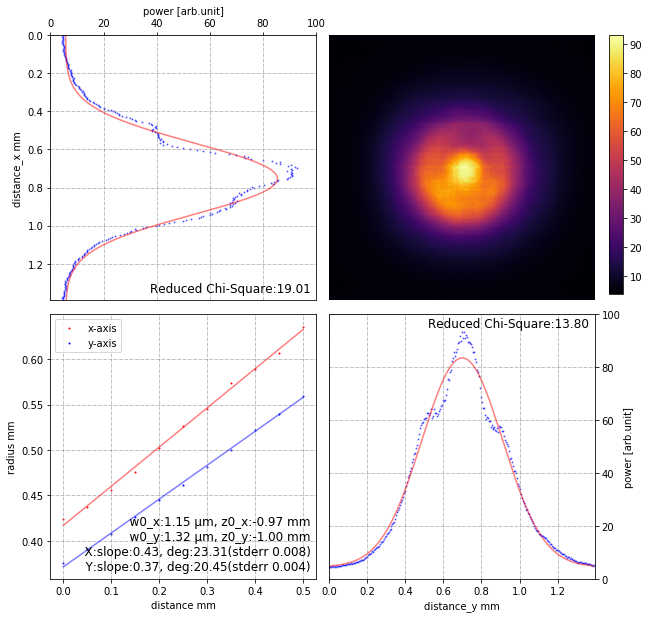

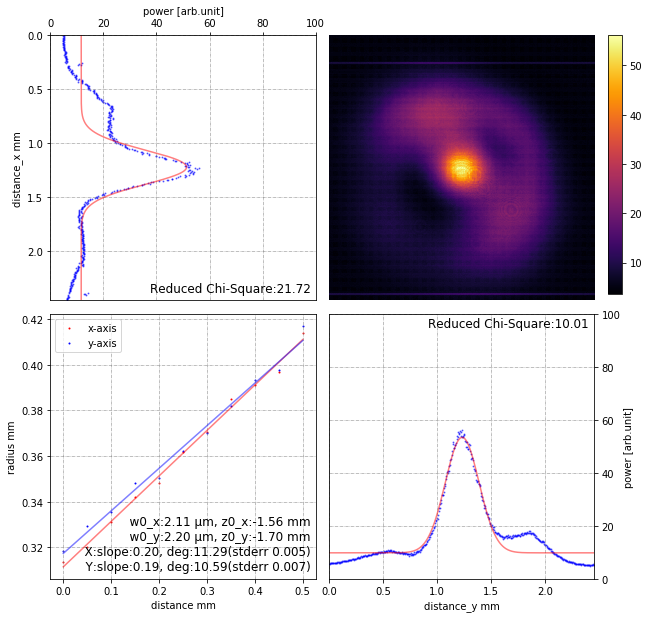

In [56]:
filePath = '/Users/guanlun/Desktop/202003/Lens Fiber/Data/Final/200/'

for name in glob.glob(filePath+'/*'):

    filelst = glob.glob(name+'/'+'*.bmp')

    main(filelst)